# Library Import


In [1]:
# Library Import
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import string
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Download the required NLTK data


In [2]:
# Download the required NLTK data
nltk.download('punkt')  # Punkt Tokenizer Model
nltk.download('stopwords')  # Stopwords
nltk.download('wordnet')  # WordNet Lemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...

[nltk_data]   Package punkt is already up-to-date!

[nltk_data] Downloading package stopwords to /root/nltk_data...

[nltk_data]   Package stopwords is already up-to-date!

[nltk_data] Downloading package wordnet to /root/nltk_data...

[nltk_data]   Package wordnet is already up-to-date!


True

# Importing and Data Preprocessing

In [3]:
# Load the dataset
df = pd.read_csv('data.csv')

In [4]:
# Remove duplicates based on the 'Sentence' column
df = df.drop_duplicates(subset='Sentence')

In [5]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [6]:
# Remove duplicates based on the 'Sentence' column
df = df.drop_duplicates(subset='Sentence')

# Lowercase the sentences
df['Sentence'] = df['Sentence'].str.lower()

# Remove punctuation
df['Sentence'] = df['Sentence'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Tokenize the sentences
df['Sentence'] = df['Sentence'].apply(word_tokenize)

# Remove stop words
stop_words = set(stopwords.words('english'))
df['Sentence'] = df['Sentence'].apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatize the words
lemmatizer = WordNetLemmatizer()
df['Sentence'] = df['Sentence'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))

# The number of most frequent words to consider

In [7]:
# The number of most frequent words to consider
MAX_NB_WORDS = 50000
# Max number of words in each complaint
MAX_SEQUENCE_LENGTH = 250
# This is fixed
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Sentence'].values)
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(df['Sentence'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [8]:
# Convert sentiments to one-hot vectors
encoder = LabelEncoder()
encoder.fit(df['Sentiment'])
Y = encoder.transform(df['Sentiment'])
Y = to_categorical(Y)

# Split into train and test sets


In [9]:
# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)

# Create model


In [10]:
# Create model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))  # 3 is the number of sentiment classes
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model


In [11]:
# Train model
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5

68/68 [==============================] - 68s 918ms/step - loss: 0.9589 - accuracy: 0.5429 - val_loss: 0.8669 - val_accuracy: 0.5574

Epoch 2/5

68/68 [==============================] - 57s 839ms/step - loss: 0.6970 - accuracy: 0.7114 - val_loss: 0.7400 - val_accuracy: 0.6827

Epoch 3/5

68/68 [==============================] - 55s 812ms/step - loss: 0.3889 - accuracy: 0.8471 - val_loss: 0.7262 - val_accuracy: 0.7077

Epoch 4/5

68/68 [==============================] - 53s 782ms/step - loss: 0.2117 - accuracy: 0.9265 - val_loss: 0.7687 - val_accuracy: 0.7077

Epoch 5/5

68/68 [==============================] - 52s 770ms/step - loss: 0.1102 - accuracy: 0.9682 - val_loss: 0.9310 - val_accuracy: 0.7328


# Evaluate the model


In [12]:
# Evaluate the model
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

17/17 [==============================] - 1s 74ms/step - loss: 0.9218 - accuracy: 0.7355

Test set

  Loss: 0.922

  Accuracy: 0.735


# Predict the sentiments for the test set and confusion matrix


17/17 [==============================] - 2s 73ms/step


<Axes: >

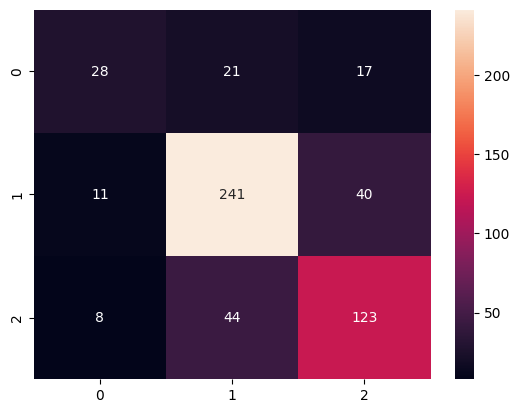

In [13]:
# Predict the sentiments for the test set
Y_pred = model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt="d")

# Generate a classification report


In [14]:
# Define your labels based on the order of your sentiment classes
labels = ['negative', 'neutral', 'positive']

# Generate a classification report
report = classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names=labels)
print(report)

              precision    recall  f1-score   support



    negative       0.60      0.42      0.50        66

     neutral       0.79      0.83      0.81       292

    positive       0.68      0.70      0.69       175



    accuracy                           0.74       533

   macro avg       0.69      0.65      0.66       533

weighted avg       0.73      0.74      0.73       533




# Assuming that 'text_to_predict' is the text for which you want to predict the sentiment


In [15]:
# Assuming that 'text_to_predict' is the text for which you want to predict the sentiment
text_to_predict = ["The stock market is doing great today!"]
sequences = tokenizer.texts_to_sequences(text_to_predict)
padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['negative', 'neutral', 'positive']
print("Predicted sentiment: ", labels[np.argmax(pred)])

1/1 [==============================] - 0s 88ms/step

Predicted sentiment:  positive


# Word Cloud with Postive, Negative and Neutral Sentiment

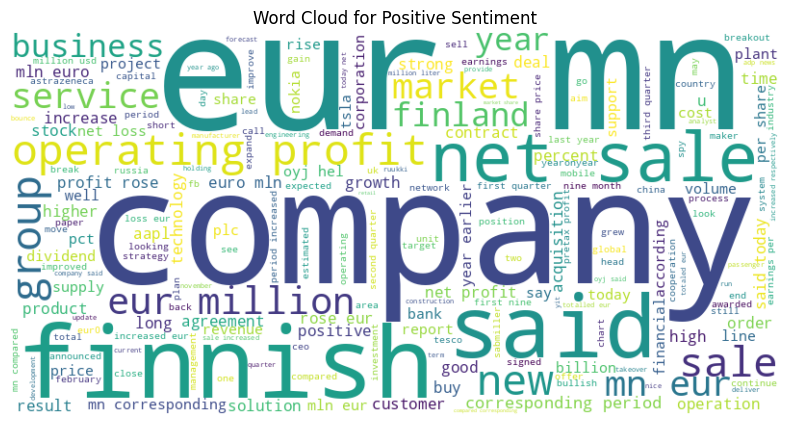

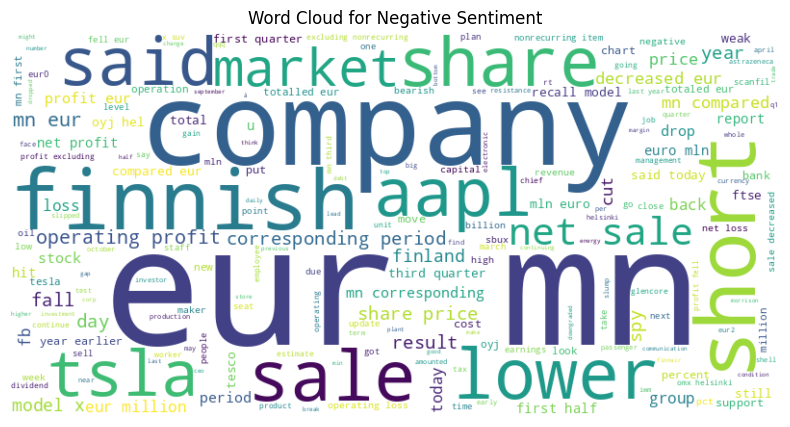

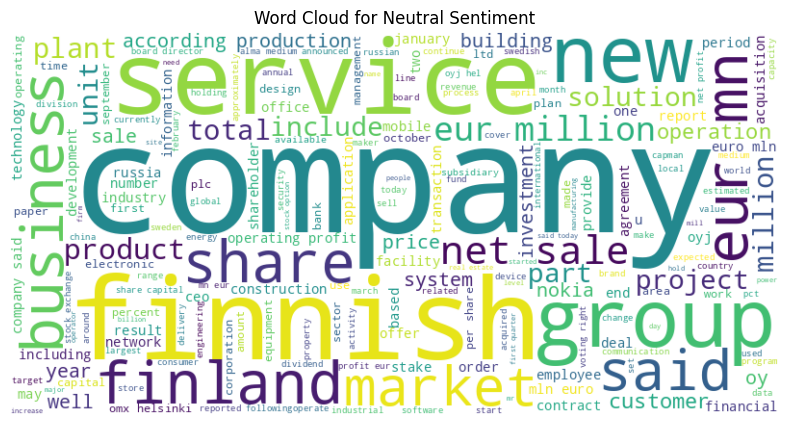

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def visualize_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

for sentiment in ['positive', 'negative', 'neutral']:
    text = ' '.join(df[df['Sentiment'] == sentiment]['Sentence'].tolist())
    visualize_wordcloud(text, f'Word Cloud for {sentiment.capitalize()} Sentiment')